# Imports

In [7]:
import NeuralNet.face_classifier as fc
import NeuralNet.Models.simpleModel as simp
import NeuralNet.Models.resnet as res
import NeuralNet.cnn_utils as cu
import FaceMorphing.morphing_utils as mu
import numpy as np
from matplotlib import pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import warnings
from skimage import io, transform, color
from torchvision import transforms, utils
import morpher
import cv2
import requests
import zipfile

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
warnings.filterwarnings("ignore")
#

# Final Workflow
### All code written by Luke Banaszak unless otherwise noted


In [4]:
# Download the zip file from this url and extract the contents into "./NeuralNet/nets"
# https://drive.google.com/file/d/1luxLEy6aK5yr1dDLNwNMVpOQown8Hsr9

best_network = res.IBugFaceKeypointResNet50(True, True)
if torch.cuda.is_available():
    best_network.cuda()
checkpoint = torch.load(".//NeuralNet//nets//resnet50-ibug_1_landmarks.pth",map_location=torch.device('cpu') )
best_network.load_state_dict(checkpoint["model_state_dict"])

Training intermediate layer parameters...


<All keys matched successfully>

In [29]:
final_morpher=morpher.Morpher(best_network)

In [34]:
# This will generate a gif animation of any images in this folder
# This might take several minutes depending on the number of images

final_morpher.make_gif(".\\Images", 'output_test.gif', frames=30)
final_morpher.make_mpeg(".\\Images", 'output_test.mp4', frames=30)

reading image: 05-3m.jpg
reading image: 14-1f.jpg
reading image: 16-4m.jpg
3 images found
predicting keypoints for image: 0
resized image from (480, 640, 3) to (480, 640, 3)
predicting keypoints for image: 1
resized image from (480, 640, 3) to (480, 640, 3)
predicting keypoints for image: 2
resized image from (480, 640, 3) to (480, 640, 3)
generating morph gif animation
reading image: 05-3m.jpg
reading image: 14-1f.jpg
reading image: 16-4m.jpg
3 images found
predicting keypoints for image: 0
resized image from (480, 640, 3) to (480, 640, 3)
predicting keypoints for image: 1
resized image from (480, 640, 3) to (480, 640, 3)
predicting keypoints for image: 2
resized image from (480, 640, 3) to (480, 640, 3)
generating morph mpeg animation


# Image Morphing

# Facial Keypoint Auto-Detection

Our program uses a Convolutional Neural Network to identify an arbitrary number of facial landmarks. Pytorch is the machine learning library used.

The network uses the Resnet50 model's architecture to process the image data. The program adds supplemental training (i.e., tuning) based on a specific set of facial landmark to a network pre-trained on similar data. 

Several network architectures were tried before deciding on the Resnet50 model. These initial networks contained approximately 10 layers compared to the Resent model's 50. Their output did not perform as well as the Resent architecture. Samples of these models' output are included in the following.

## Data Pipeline

The dataset used for tuning the final model, as well as fully training the initial models, consisted of jpg and a corresponding ".asf" file. The asf file describes the landmarks for the associated image.
Each point is described as a normalized coordinate, the associated points, and the type of path they comprise (closed, open, etc.) Each image had 58 landmark points.


To ingest the data into the model, a custom class inheriting the default PyTorch Dataset class is used. The landmark data is parsed from each file into a single Pandas dataframe that cooperates with PyTorch indexing. 

In [22]:
imagedir=".\\NeuralNet\\Data"
with zipfile.ZipFile('./NeuralNet/Images.zip', 'r') as zip_ref:
    zip_ref.extractall('./NeuralNet')

header = ['path', 'type', 'xrel', 'yrel', 'point', 'connects_from', 'connects_to']
skiprows = np.hstack((np.arange(0,16), np.arange(75,81)))
directory = os.fsencode(imagedir)
frame = fc.build_frame(directory=directory, imagedir=imagedir, header=header, skiprows=skiprows)

The final model supports arbitrary image sizes and full color, but transforms are available to standardize image size and to convert to grayscale. These were used primarily for the initial, simpler models that required a consistent image size and did not support color.

In [23]:
#Put together the transformations we'll perform on the input images
composed = transforms.Compose([fc.Rescale((120,160)), fc.ToGray(), fc.ToTensor()])

In [25]:
#instantiate the custom dataset
total_images = len(frame.index.unique())
print(f'Total images: {total_images}')
test_frac = 0.10

valid_split = int(total_images * test_frac)
train_split = int(total_images - valid_split)

training_samples = frame.loc[:train_split - 1]
testing_samples = frame.loc[train_split:]

train_data = fc.FaceLandmarksDataset(
    frame=training_samples, root_dir=imagedir, transform=composed
)
test_data = fc.FaceLandmarksDataset(
    frame=testing_samples, root_dir=imagedir, transform=composed
)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(test_data)}")

Total images: 240
Training sample instances: 216
Validation sample instances: 24


A key function within the custom dataset is the __get__ method implementing how instances of data are retrieved. An additional layer is added to this retrieval behavior with a Dataloader, though, which allows for parameterization of retrieval variables that influence the training of the model.

## Training the Model

Training the model requires a Dataloader. The Dataloader adds additional parameterization for how data is fetched for processing through the model during training and testing.

In [26]:
#Create a dataloader for dataset we created - decide on batch size
train_dataloader = DataLoader(train_data, batch_size=10,
                        shuffle=True, num_workers=0)
test_dataloader = DataLoader(
    test_data, 
    batch_size=10, 
    shuffle=False, 
    num_workers=0, 
    sampler=range(testing_samples.index.min(), testing_samples.index.max())
)

### Simple Model

With the Dataloader working, we can begin feeding the landmark data and images through a neural network. Our first model was structured using a basic guideline for architectures for our specific task. The model uses 3 convolutional layers that result in 128 channels.

In [30]:
simple = simp.FaceKeypointModel2()
if torch.cuda.is_available():
    simple.cuda()


We use mean squared error as the loss calculation for training the model. The model is then optimized used the ADAM algorithm.

In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(simple.parameters(), lr=0.0003)

In [32]:
cu.train(model=simple,train_dataloader=test_dataloader,optimizer=optimizer,criterion=criterion,epoch=10)

6237.07958984375

In [33]:
training_loss, validation_loss = cu.train_and_validate(simple, train_dataloader, optimizer, criterion, test_dataloader, 10)

Epoch: 1, Batch: 10, Avg. Training Loss: 5910.7267578125
Epoch: 1, Batch: 20, Avg. Training Loss: 4727.711785888672
Epoch: 1, Batch: 1, Avg. Validation Loss: 1203.695068359375
Epoch: 1, Batch: 2, Avg. Validation Loss: 1135.9151611328125
Epoch: 1, Batch: 3, Avg. Validation Loss: 1021.6292114257812
Finished Validating
Epoch: 2, Batch: 10, Avg. Training Loss: 635.7467956542969
Epoch: 2, Batch: 20, Avg. Training Loss: 444.0734489440918
Epoch: 2, Batch: 1, Avg. Validation Loss: 197.75784301757812
Epoch: 2, Batch: 2, Avg. Validation Loss: 209.48168182373047
Epoch: 2, Batch: 3, Avg. Validation Loss: 248.83947245279947
Finished Validating
Epoch: 3, Batch: 10, Avg. Training Loss: 167.4519172668457
Epoch: 3, Batch: 20, Avg. Training Loss: 166.31521949768066
Epoch: 3, Batch: 1, Avg. Validation Loss: 116.1791763305664
Epoch: 3, Batch: 2, Avg. Validation Loss: 122.4466438293457
Epoch: 3, Batch: 3, Avg. Validation Loss: 146.36389923095703
Finished Validating
Epoch: 4, Batch: 10, Avg. Training Loss: 

Review some sample outputs

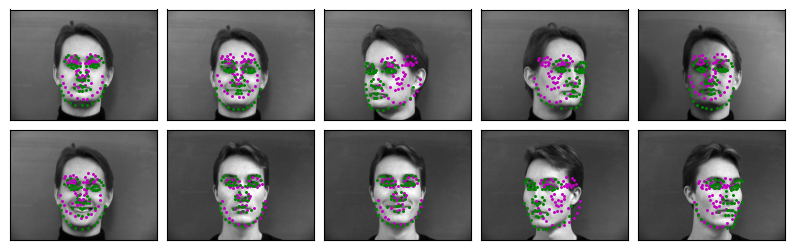

In [34]:
for test_images, test_outputs, gt_pts in cu.net_sample_output(simple, test_dataloader):
    cu.visualize_output(test_images, test_outputs, gt_pts)

Review the model's learning performance

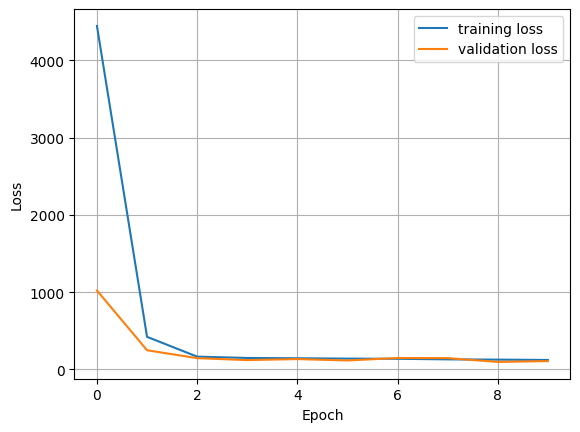

In [35]:
plt.figure()
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

### Resnet Model

At this point in the project we had developed an intuition for CNN architectures: the role of layers and filters, hyper parameters, the training process, etc. We experimented with different values to improve our simple model and decided to see how much better well-known, established architectures performed. 

Our research identified the Resnet50 model as an example of a standard architecture for CNNs.

In [36]:
resnet50_model = res.FaceKeypointResNet50(True, True)
if torch.cuda.is_available():
    resnet50_model.cuda()


Training intermediate layer parameters...


We use an instance of the model pre-trained on facial landmark identification data, but we then used the working knowledge of CNNs we developed to continue training the model to tune it to our dataset.

The model supports color images, unlike the original, so they do not need to be converted to grayscale, first.

In [38]:
#Put together the transformations we'll perform on the input images
composed = transforms.Compose([fc.Rescale((120,160)), fc.Normalize(), fc.ToTensor()])
#instantiate the custom dataset
total_images = len(frame.index.unique())
print(f'Total images: {total_images}')
test_frac = 0.10

valid_split = int(total_images * test_frac)
train_split = int(total_images - valid_split)

training_samples = frame.loc[:train_split - 1]
testing_samples = frame.loc[train_split:]

train_data = fc.FaceLandmarksDataset(
    frame=training_samples, root_dir=imagedir, transform=composed
)
test_data = fc.FaceLandmarksDataset(
    frame=testing_samples, root_dir=imagedir, transform=composed
)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(test_data)}")

Total images: 240
Training sample instances: 216
Validation sample instances: 24


In [39]:
#Create a dataloader for dataset we created - decide on batch size
train_dataloader = DataLoader(train_data, batch_size=10,
                        shuffle=True, num_workers=0)
test_dataloader = DataLoader(
    test_data, 
    batch_size=10, 
    shuffle=False, 
    num_workers=0, 
    sampler=range(testing_samples.index.min(), testing_samples.index.max())
)

In [40]:
# Must train for ~ 25 epochs for best results - may take several minutes

training_loss, validation_loss = cu.train_and_validate(resnet50_model, train_dataloader, optimizer, criterion, test_dataloader, 2)

Epoch: 1, Batch: 10, Avg. Training Loss: 5973.972900390625
Epoch: 1, Batch: 20, Avg. Training Loss: 5941.886791992188
Epoch: 1, Batch: 1, Avg. Validation Loss: 6192.9541015625
Epoch: 1, Batch: 2, Avg. Validation Loss: 6244.954345703125
Epoch: 1, Batch: 3, Avg. Validation Loss: 6241.728190104167
Finished Validating
Epoch: 2, Batch: 10, Avg. Training Loss: 5982.25517578125
Epoch: 2, Batch: 20, Avg. Training Loss: 5973.686743164062
Epoch: 2, Batch: 1, Avg. Validation Loss: 6188.89111328125
Epoch: 2, Batch: 2, Avg. Validation Loss: 6241.151611328125
Epoch: 2, Batch: 3, Avg. Validation Loss: 6238.571451822917
Finished Validating
Finished Training and Validating


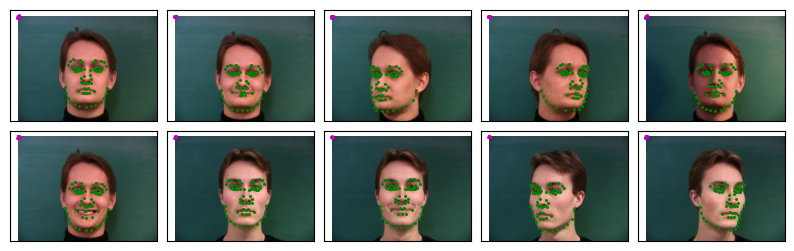

In [41]:
for test_images, test_outputs, gt_pts in cu.net_sample_output(resnet50_model, test_dataloader):
    cu.visualize_output(test_images, test_outputs, gt_pts)